In [2]:
import baltic as bt
from matplotlib import pyplot as plt
from collections import defaultdict
from matplotlib import cm
from numpy import linspace
%matplotlib inline
import json
import matplotlib.gridspec as gridspec
import math
from itertools import combinations
import pandas as pd
import numpy as np
import seaborn as sns
from pprint import pprint
import math
import sequtils as sue
from scipy.stats import linregress

In [3]:
dataset_name = 'SEAsia_stiffness2'
out_path = '../../data/frequencies/regions/'
frequencies = pd.read_csv('../../data/frequencies/regions/seAsia_stiffness2_pivots4.csv', index_col=0)
frequencies.drop([gt for gt in frequencies.columns.values if 'SYLVATIC' in gt], inplace=True, axis=1)
genotypes = frequencies.columns.values


titer_path = '../../data/katzelnick2015/processed/genotypes_dTiters.csv'
print frequencies.head()

           DENV1_I  DENV1_II  DENV1_IV  DENV1_V  DENV2_AMERICAN  \
1970.1667   0.0245    0.0587    0.0040   0.1279             0.0   
1970.4167   0.0232    0.0504    0.0038   0.1383             0.0   
1970.6667   0.0216    0.0430    0.0036   0.1484             0.0   
1970.9167   0.0199    0.0360    0.0033   0.1573             0.0   
1971.1667   0.0209    0.0346    0.0034   0.1939             0.0   

           DENV2_ASIANAMERICAN  DENV2_ASIANI  DENV2_ASIANII  \
1970.1667               0.1678        0.1268         0.0150   
1970.4167               0.1554        0.1174         0.0139   
1970.6667               0.1430        0.1080         0.0128   
1970.9167               0.1306        0.0987         0.0117   
1971.1667               0.1263        0.0955         0.0113   

           DENV2_COSMOPOLITAN  DENV3_I  DENV3_II  DENV3_III  DENV3_V  DENV4_I  \
1970.1667              0.0051      0.0    0.0238     0.0071   0.0050   0.0089   
1970.4167              0.0047      0.0    0.0235     0.0

In [29]:
dTiters = pd.read_csv(titer_path, index_col=0, header=None, names=['gt1', 'gt2', 'dTiter'])
titers = {}
for idx, i in dTiters.iterrows():
    key = tuple(sorted([i['gt1'], i['gt2']]))
    titers[key] = i['dTiter']

In [30]:
def are_cocirculating(genotype1, genotype2, row):
    return row[genotype1] >= 0.1 and row[genotype2] >= 0.1

def avg_len_cocirculating(flag_series):  
    # first value is a True preceded by a False
    start = flag_series.index[flag_series & ~ flag_series.shift(1).fillna(False)]

    # last value is a True followed by a False
    end = flag_series.index[flag_series & ~ flag_series.shift(-1).fillna(False)]
        
    time_periods = zip(start, end)
    len_cocirculating = [end - start for start,end in time_periods]
    
    try:
        avg_len_cocirculating = float(sum(len_cocirculating)) / float(len(len_cocirculating))
    except ZeroDivisionError:
        avg_len_cocirculating = 0.

    assert avg_len_cocirculating >= 0.
    return avg_len_cocirculating


def get_cocirculation_stability(df, genotypes=genotypes):
    genotype_pairs = combinations(genotypes, 2)
    
    len_cocirc = {}
    
    for (g1,g2) in genotype_pairs:
        cocirculating_boolean_series = df.apply(lambda x: are_cocirculating(g1,g2,x), axis=1)
        key = tuple(sorted([g1,g2]))
        len_cocirc[key] = avg_len_cocirculating(cocirculating_boolean_series)
    
    return len_cocirc

def both_present((g1, g2), df):
    max_freqs = df.max()
    return max_freqs[g1] >= 0.1 and max_freqs[g2] >=0.1

In [53]:
def compare_cocirculation_stability_titers(df, titers=titers, genotypes=genotypes):
    len_cocirc = get_cocirculation_stability(df)
    
    xvals = []
    yvals = []
    homotypic = []

    for gt, val in len_cocirc.items():
        x = titers[gt]
        y = len_cocirc[gt]
        if not np.isnan(x) and y > 0:
            xvals.append(x)
            yvals.append(y)

            if gt[0].split('_')[0]==gt[1].split('_')[0]:
                homotypic.append(True)
            else:
                homotypic.append(False)

    fit = linregress(xvals, yvals)
    
    vals = pd.DataFrame({'dTiter': xvals, 'cocirculation': yvals, 'homotypic': homotypic})
    fit = {'rvalue': fit.rvalue, 'slope': fit.slope}
    return {'vals': vals, 'fit': fit}

def shuffle_labels(df):
    shuffled = df.copy()
    np.random.shuffle(shuffled.columns.values)
    return shuffled

def generate_null(df, n=100):
    null_distribution_slope = []
    null_distribution_r = []
    for i in range(n):
        shuffled_df = shuffle_labels(df)
        null_distribution_slope.append(compare_cocirculation_stability_titers(shuffled_df)['fit']['slope'])
        null_distribution_r.append(compare_cocirculation_stability_titers(shuffled_df)['fit']['rvalue'])
    return {'r': null_distribution_r, 'slope': null_distribution_slope}

In [54]:
actual = compare_cocirculation_stability_titers(frequencies)

(0, 5.3805865684905205)

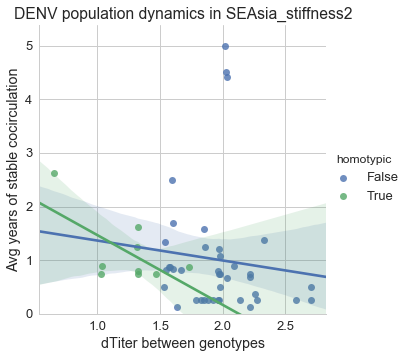

In [55]:
sns.set(style='whitegrid', font_scale=1.3)
sns.lmplot('dTiter', 'cocirculation', hue='homotypic', data = actual['vals'])
plt.xlabel('dTiter between genotypes')
plt.ylabel('Avg years of stable cocirculation')
plt.title('DENV population dynamics in %s'%dataset_name)
plt.ylim(bottom=0)
# plt.savefig(out_path+'/'+dataset_name+'_genotype_cocirculation.png')

In [56]:
null_distrib = generate_null(frequencies)

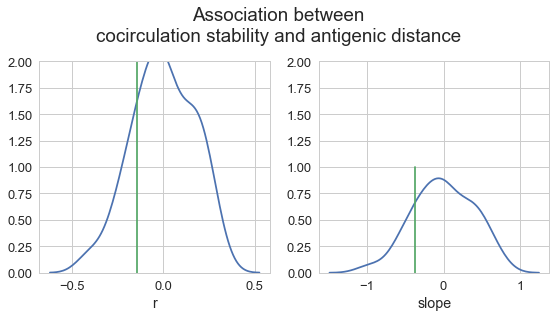

In [58]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
null_r = sns.kdeplot(pd.Series(null_distrib['r']), ax=ax[0])
null_r.plot([actual['fit']['rvalue'] for i in np.linspace(0.,2.)], [i for i in np.linspace(0.,2.)])
null_r.set_xlabel('r')
null_r.set_ylim(0, 2)

null_slope = sns.kdeplot(pd.Series(null_distrib['slope']), ax=ax[1])
null_slope.plot([actual['fit']['slope'] for i in np.linspace(0.,1.)], [i for i in np.linspace(0.,1.)])
null_slope.set_xlabel('slope')
null_slope.set_ylim(0,2)

plt.suptitle('Association between\ncocirculation stability and antigenic distance', va='bottom')
plt.tight_layout()
# plt.savefig(out_path+'/'+dataset_name+'_genotype_cocirculation_null.png')